we import some clmm modules

In [1]:
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMM/examples/support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import clmm.polaraveraging as pa

we import module for mock data

In [2]:
import mock_data as mock

modules

In [3]:
import pickle
import os
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from scipy.optimize import curve_fit

we import `DC2Analysis` modules

In [4]:
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')
import stacking as stack
import modelling as model
import mock as mock_extension

for reproductibility

In [5]:
np.random.seed(11)

we define the `Stacking` object `shear` by definning a background cosmology, a given range of radial axis and the number of bins for the binned stacked shear profile.

In [6]:
cosmo = FlatLambdaCDM(H0=71 * u.km / u.s / u.Mpc, Tcmb0=0 * u.K, Om0=0.265, Ob0 = 0.0448, Neff = 3.04, m_nu=None)
shear = stack.Stacking( r_low = 0.2,  r_up = 5, n_bins = 15, cosmo = cosmo)

we now define the type of desired profile : tangential reduced shear of Excess surface density for the stacking procedure by modifying the atribute. We use the method `Type` from the class to select DeltaSigma of reduced tangential shear.

In [7]:
deltasigma = False

In [8]:
shear.SelectType(is_deltasigma = deltasigma)

We now define some redshift interval and input mass interval to select GalaxyCluster object in preselected galaxy catalogs from `cosmoDC2`

In [9]:
z_bin = [0.4,0.5]
m_bin = [1*10**14, 1.2*10**14] #Solar Mass
m_bin = np.array(m_bin)
n_catalogs = 50
ngals = 20000

we define a set of selected cluster with given true masses ans true redshifts

In [10]:
cluster_m = (m_bin[1] - m_bin[0])*np.random.random(n_catalogs) + m_bin[0]
cluster_z = (z_bin[1] - z_bin[0])*np.random.random(n_catalogs) + z_bin[0]

We add each galaxy catalogs that correponds to binning criteria to the `shear` object through the `Add(self,'file_name')` method.

In [11]:
for i in range(n_catalogs):
    
    c = model.Duffy_concentration(cluster_m[i], cluster_z[i])
    
    data = mock.generate_galaxy_catalog(cluster_m[i]*cosmo.h, cluster_z[i], c, cosmo,  200,'chang13', zsrc_min = cluster_z[i] + 0.1 ,shapenoise = 0.01,ngals=ngals)
    
    cl = clmm.GalaxyCluster('cluster', 0, 0, cluster_z[i], data)
    
    mock_extension._add_pdf_z(cl, sigma_z_unscaled = 0.03)
    
    shear.AddCatalog(cl, Shapenoise = False)

/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


we can see how much catalogs have been selected

In [12]:
print(f'we selected {shear.n_stacked_gt} clusters')

we selected 50 clusters


The attribute `profile` of `shear` object is filled using the method `MakeShearProfile`, where the stacking method can be choosen as `'classical'` or weighted `'error weighted'`. The number of selected galaxy catalogs is visible with `n_stacked_gt` attribute

In [13]:
shear.MakeShearProfile('error weighted')

The `profile` attribute is an astropy table containing the binned profile `gt` the error `gt_err` along the radial axis `radius`

### Visualization of the results

we visualize the reduced tangential stacked shear and we calculate the predicted reduced shear when using the average innput mass of selected clusters. We also visualize individual shear profiles.

In [14]:
profile = shear.profile

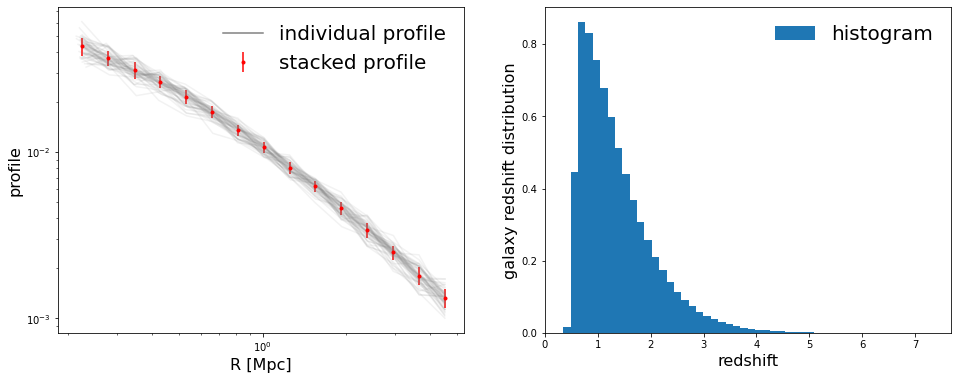

In [15]:
#plt.errorbar(profile_classical['radius'], profile_classical['gt'], profile_classical['gt_err'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i in range(shear.n_stacked_gt):
    
    axes[0].plot(shear.radial_axis_list[i],shear.gt_list[i],c='grey',alpha=0.1)
    

axes[0].plot([],[],c='grey', label='individual profile')    
axes[0].errorbar(profile['radius'], profile['gt'],profile['gt_err'], color='red', label='stacked profile', fmt='.')
axes[0].set_xlabel('R [Mpc]', fontsize=16)
axes[0].set_ylabel('profile', fontsize=16)
axes[0].legend(fontsize=20, frameon=False)
axes[0].semilogx()
axes[0].semilogy()
axes[1].hist(shear.z_galaxy_list, bins = 50,label='histogram', density = True)
axes[1].set_xlabel('redshift', fontsize=16)
axes[1].set_ylabel('galaxy redshift distribution', fontsize=16)
axes[1].legend(fontsize=20, frameon=False)
plt.show()

### Defining a model and a fitting procedure

we select the model to fit following the type of profile.

In [16]:
def model_data(r,logm):
    if shear.is_deltasigma == False:
        return model.predict_reduced_tangential_shear_z_distrib(r, logm, shear.average_z, shear.z_galaxy_list, cosmo)

    else:
        return model.predict_excess_surface_density(r, logm, shear.average_z, shear.z_galaxy_list, cosmo)

### Fitting a halo mass

we fit the Halo mass using `scipy` module.

In [17]:
param_p0 = [14.]
param_bounds = ([13. ], [16.])
logm_fit, cov_logm_fit = curve_fit(model_data, profile['radius'], profile['gt'], sigma = profile['gt_err'], bounds = param_bounds, p0 = param_p0)

/pbs/home/c/cpayerne/.local/lib/python3.7/site-packages/clmm-0.3.0-py3.7.egg/clmm/modbackend/cluster_toolkit.py:272: RuntimeWarning: divide by zero encountered in true_divide
/pbs/home/c/cpayerne/.local/lib/python3.7/site-packages/clmm-0.3.0-py3.7.egg/clmm/modbackend/cluster_toolkit.py:275: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.local/lib/python3.7/site-packages/clmm-0.3.0-py3.7.egg/clmm/modbackend/cluster_toolkit.py:415: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/pbs/home/c/cpayerne/.local/lib/python3.7/site-packages/clmm-0.3.0-py3.7.egg/clmm/modbackend/cluster_toolkit.py:346: UserWarning: Some source redshifts are lower than the cluster redshift. shear = 0 for those galaxies.
/pbs/home/c/cpayerne/.local/lib/python3.7/site-packages/clmm-0.3.0-py3.7.egg/clmm/modbackend/cluster_toolkit.py:478: UserWarning: Some source redshi

In [18]:
m_fit = float(10**logm_fit)
err_m_fit = float(m_fit * np.sqrt(cov_logm_fit[0][0]) * np.log(10))

In [19]:
print(f'Best fit mass for cluster 1 = {m_fit:.2e} +/- {err_m_fit:.2e} Msun')
print(f'Average mass = {np.mean(cluster_m):.2} Msun')

Best fit mass for cluster 1 = 1.11e+14 +/- 4.05e+11 Msun
Average mass = 1.1e+14 Msun


In [20]:
r = np.linspace(0.2,5,1000)
if deltasigma == False:
    y_fit = model.predict_reduced_tangential_shear_z_distrib(r, logm_fit, shear.average_z, shear.z_galaxy_list, cosmo)
    
else:
    y_fit = model.predict_excess_surface_density(r, logm_fit, shear.average_z, shear.z_galaxy_list, cosmo)

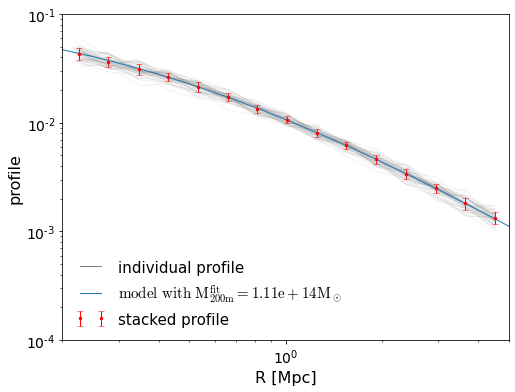

In [21]:
plt.figure(figsize=(8,6))
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.grid(True, ls = '--')
plt.style.use('classic')

for i in range(shear.n_stacked_gt):
    
    plt.plot(shear.radial_axis_list[i],shear.gt_list[i],c='grey',alpha=0.1)
    
plt.plot([],[],c='grey', label='individual profile')
plt.errorbar(profile['radius'], profile['gt'],profile['gt_err'], color='red', label='stacked profile', fmt='.')
plt.plot(r,y_fit, label=r'$\rm{model\ with}\ M^{fit}_{200m} = %.2e M_\odot$'%(m_fit))
plt.xlabel('R [Mpc]', fontsize=16)
plt.ylabel('profile', fontsize=16)

plt.legend(fontsize=15, frameon=False, loc='best')
plt.semilogx()
plt.semilogy()
plt.xlim(0.2,5)
plt.show()